<p align="center">
    <img src="https://github.com/YoungsukHan/Hyundai_equip/assets/44924554/076ffad6-abf4-431b-af15-10373ba06182" align="center">
</p>

# <b>[ML] 용해탱크 시계열 데이터 실습 

**제목:** 용해탱크 설비운영 데이터 기반 제품의 최종품질을 예측<br>
**Description:** 용해탱크로부터 수집한 설비운영 데이터를 수집 후, 머신러닝 모형을 학습하여 제품의 최종품질을 예측함

https://www.kamp-ai.kr/aidataDetail?AI_SEARCH=&page=1&DATASET_SEQ=8

<img src="https://www.kamp-ai.kr/mnt/dataset/8/images/1.png">

<img src="https://github.com/seohyunc/hyundai/blob/main/img/melting_process.png?raw=true" width="40%"/>

## **1. 데이터 불러오기**

In [1]:
import time
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import *
from imblearn.under_sampling import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
# 데이터셋 불러오기
df = pd.read_csv('dataset/melting_tank.csv', encoding='cp949')
df.head()

,STD_DT,NUM,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
0,2020-03-04 0:00,0,489,116,631,3.19,OK
1,2020-03-04 0:00,1,433,78,609,3.19,OK
2,2020-03-04 0:00,2,464,154,608,3.19,OK
3,2020-03-04 0:00,3,379,212,606,3.19,OK
4,2020-03-04 0:00,4,798,1736,604,3.21,OK


In [3]:
df['STD_DT'] = pd.to_datetime(df['STD_DT'], format='%Y-%m-%d %H:%M')

In [4]:
# STD_DT에 초 추가 (6초 단위로 기록)
for i in range(10):
    df.loc[df['NUM']%10==i, 'STD_DT'] = df.loc[df['NUM']%10==i, 'STD_DT'] + pd.to_timedelta(6*i, unit='s')

# 인덱스를 시간으로 지정
df = df.set_index(['STD_DT'])
df.drop(columns=['NUM'], axis=1, inplace=True)

df.head()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
STD_DT,,,,,
2020-03-04 00:00:00,489,116,631,3.19,OK
2020-03-04 00:00:06,433,78,609,3.19,OK
2020-03-04 00:00:12,464,154,608,3.19,OK
2020-03-04 00:00:18,379,212,606,3.19,OK
2020-03-04 00:00:24,798,1736,604,3.21,OK


In [5]:
# 데이터셋 불균형 확인
df['TAG'].value_counts()

TAG
OK    658133
NG    177067
Name: count, dtype: int64

In [6]:
# 데이터 개수 확인
# .shape[0]: 열의 개수 / .shape[1]: 행의 개수
df.shape

(835200, 5)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 835200 entries, 2020-03-04 00:00:00 to 2020-04-30 23:59:54
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   MELT_TEMP    835200 non-null  int64  
 1   MOTORSPEED   835200 non-null  int64  
 2   MELT_WEIGHT  835200 non-null  int64  
 3   INSP         835200 non-null  float64
 4   TAG          835200 non-null  object 
dtypes: float64(1), int64(3), object(1)
memory usage: 38.2+ MB


## **2. 데이터 특성 파악**

**요약 통계량**

In [8]:
# 데이터셋 통계 요약
df.describe()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP
count,835200.000000,835200.000000,835200.000000,835200.000000
mean,509.200623,459.782865,582.962125,3.194853
std,128.277519,639.436413,1217.604433,0.011822
min,308.000000,0.000000,0.000000,3.170000
25%,430.000000,119.000000,186.000000,3.190000
50%,469.000000,168.000000,383.000000,3.190000
75%,502.000000,218.000000,583.000000,3.200000
max,832.000000,1804.000000,55252.000000,3.230000


In [9]:
df_desc = df.groupby(['TAG']).describe().T.reset_index()
df_desc = df_desc.loc[df_desc['level_1'].isin(['mean', 'min', 'max'])]
df_desc.pivot(index='level_0', columns='level_1', values=['NG', 'OK'])

NG                            OK                    
level_1           max        mean     min       max        mean     min
level_0                                                                
INSP             3.21    3.188640    3.17      3.23    3.196524    3.17
MELT_TEMP      555.00  432.390112  308.00    832.00  529.866061  311.00
MELT_WEIGHT  55252.00  611.327763    0.00  52727.00  575.330509    0.00
MOTORSPEED     270.00  133.474696    0.00   1804.00  547.574252    0.00

In [10]:
# 관심 주제를 1(NG)
df.loc[df['TAG']=='NG', 'TAG'] = 1
df.loc[df['TAG']=='OK', 'TAG'] = 0

df['TAG'].value_counts()

TAG
0    658133
1    177067
Name: count, dtype: int64

**Histogram**

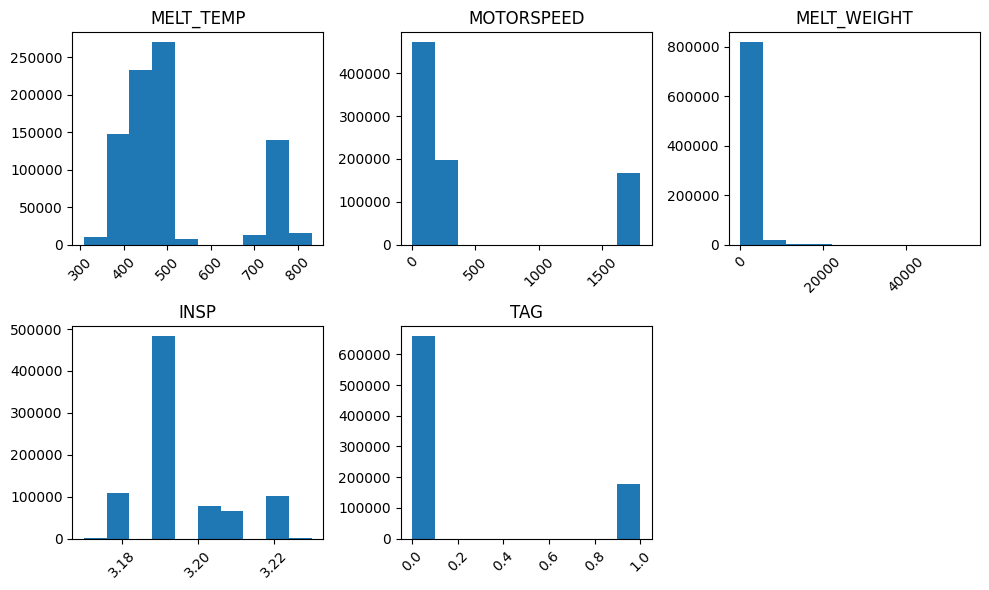

In [11]:
plt.figure(figsize=(10,6))

for i, col in enumerate(df.columns):
    num = 231+i
    plt.subplot(num)
    plt.hist(df[col])
    plt.xticks(rotation=45)
    plt.title(col)

plt.tight_layout()
plt.show()

In [12]:
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sample.html
# .sample(): 랜덤 샘플링

df_rand = df.sample(n=int(len(df)/2), random_state=0)

print(f"랜덤 샘플링 전: {df.shape}")
print(f"랜덤 샘플링 후: {df_rand.shape}")

랜덤 샘플링 전: (835200, 5)
랜덤 샘플링 후: (417600, 5)


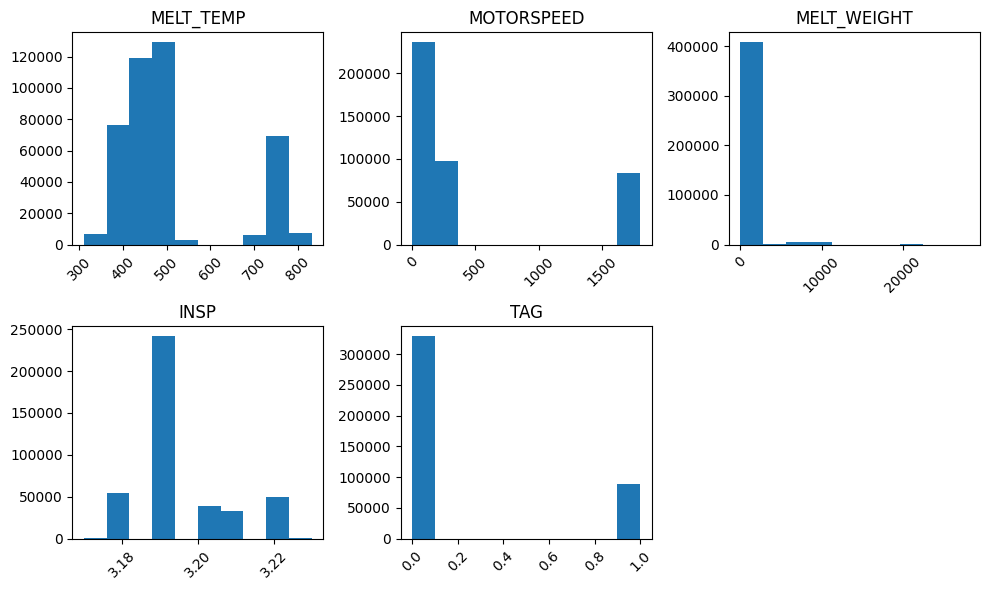

In [13]:
plt.figure(figsize=(10,6))

for i, col in enumerate(df_rand.columns):
    num = 231+i
    plt.subplot(num)
    plt.hist(df_rand[col])
    plt.xticks(rotation=45)
    plt.title(col)

plt.tight_layout()
plt.show()

<b>Density plot</b>

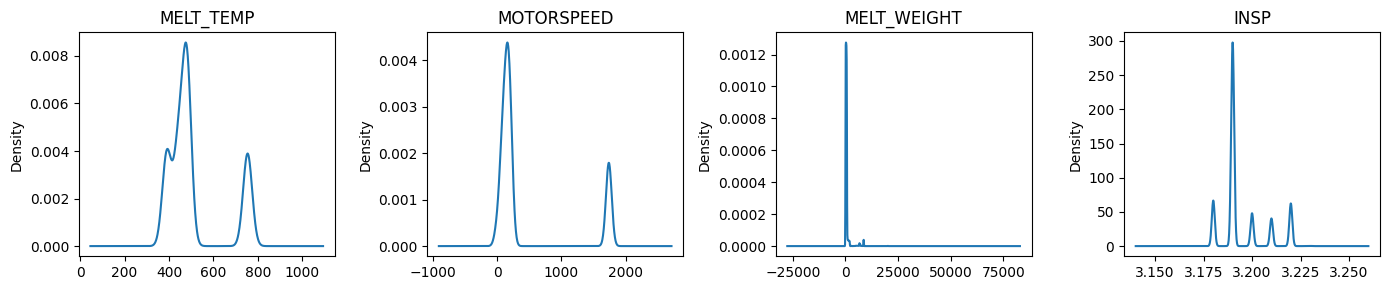

<Figure size 640x480 with 0 Axes>

In [20]:
selected_col = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP']

plt.figure(figsize=(14,3))

for i, col in enumerate(selected_col):
    num = 141+i
    plt.subplot(num)
    # sns.violinplot(data=df_rand, y=col)
    df[col].plot(kind='density')
    plt.title(col)

plt.tight_layout()
plt.show()

plt.tight_layout()      # 그래프 요소가 겹치지 않도록 레이아웃 조정
plt.show()

**Violin Plot**

<img src="https://blog.kakaocdn.net/dn/b0CIEt/btqCy3Aazjb/emj6zXRBK6UBUc8iolba81/img.png">

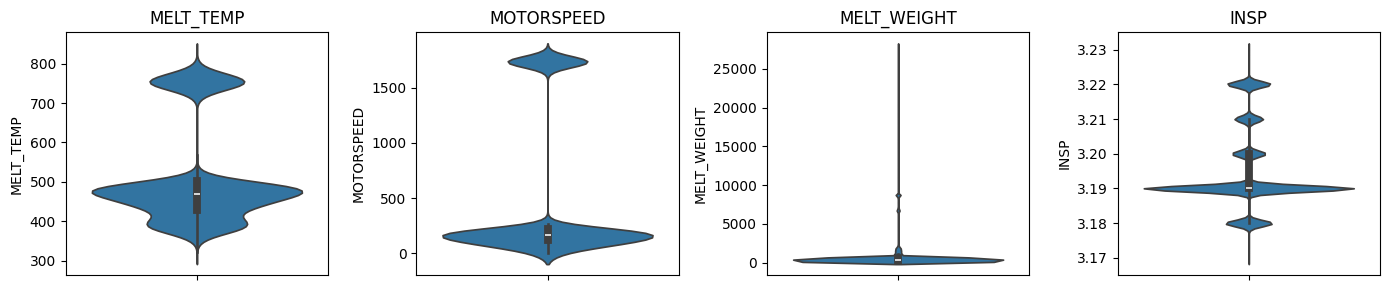

In [14]:
####### violin plot 단변수 추가

plt.figure(figsize=(14,3))

# TAG를 제외한 변수의 바이올린차트 그리기
for i, col in enumerate(selected_col):
    num = 141+i
    plt.subplot(num)
    sns.violinplot(data=df_rand, y=col)
    plt.title(col)

plt.tight_layout()
plt.show()

**Correlation Heatmap**

In [15]:
# 변수간 상관관계 확인

# 1)연속형(숫자로 표현 가능한) 데이터에 대해서만 상관관계 분석 가능
# 2) 범위: -1~1 (+: 양의 상관관계, -: 음의 상관관계)
# 3) 인과관계를 의미하지는 않음

df.corr()

,MELT_TEMP,MOTORSPEED,MELT_WEIGHT,INSP,TAG
MELT_TEMP,1.000000,0.944929,-0.000336,0.916295,0.310586
MOTORSPEED,0.944929,1.000000,0.000123,0.887813,0.264693
MELT_WEIGHT,-0.000336,0.000123,1.000000,-0.000005,-0.012084
INSP,0.916295,0.887813,-0.000005,1.000000,0.272580
TAG,0.310586,0.264693,-0.012084,0.272580,1.000000


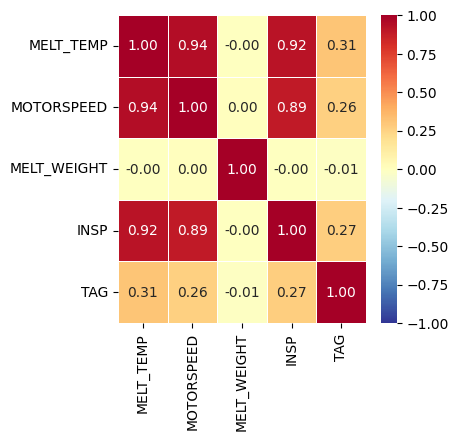

In [16]:
plt.figure(figsize=(4,4))
sns.heatmap(
    data=df.corr(),
    annot=True, 
    fmt = '.2f', 
    linewidths=.5, 
    cmap='RdYlBu_r', # Blue
    vmin=-1, vmax=1  # 컬러바 범위 -1 ~ 1
)
plt.show()

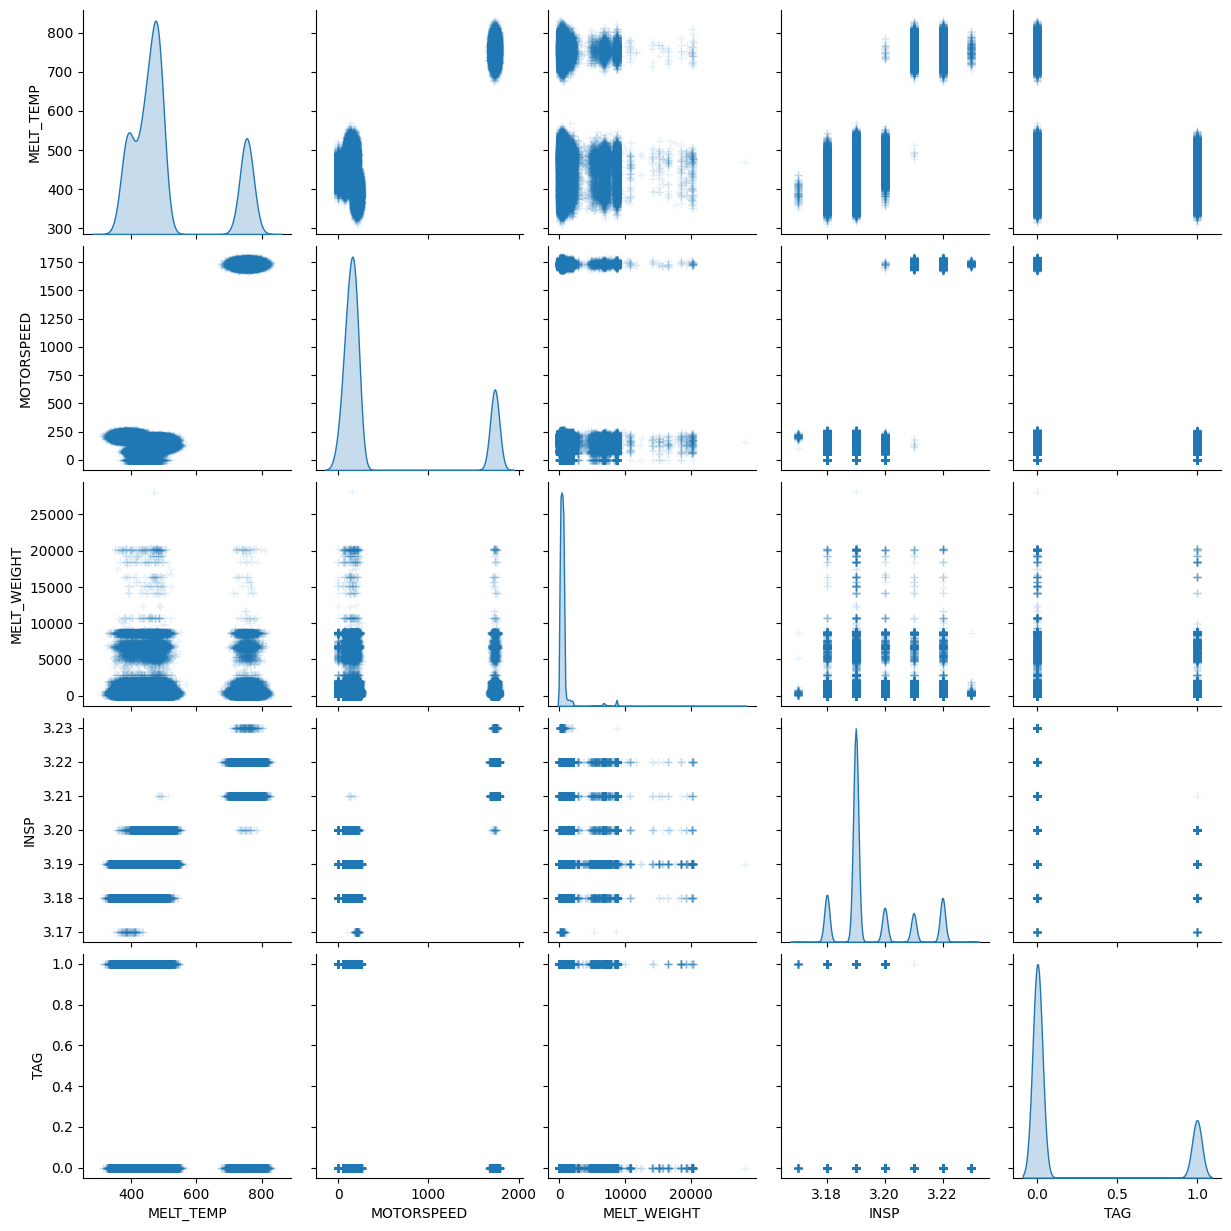

Execution time: 25.938283681869507 seconds


In [19]:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
start_time = time.time()

sns.pairplot(df_rand, diag_kind='kde', plot_kws=dict(marker="+", linewidth=1, alpha=0.1))
plt.show()

end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

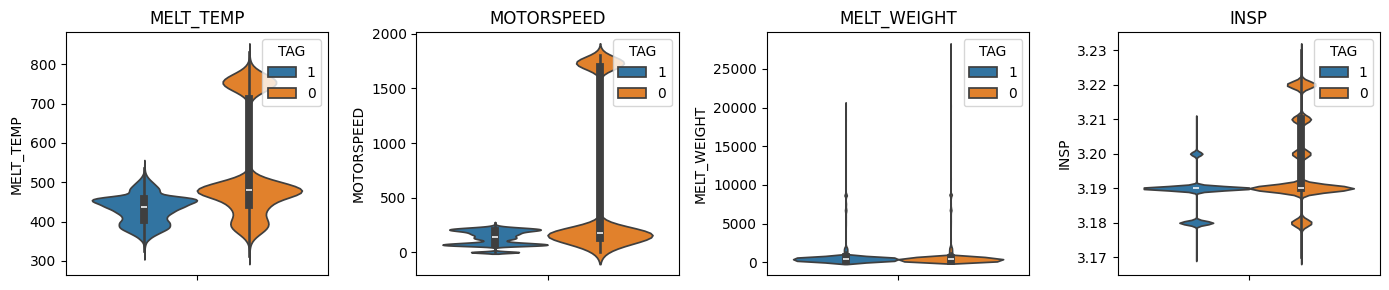

In [22]:
# selected_col = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP']

plt.figure(figsize=(14,3))

# TAG를 제외한 변수의 바이올린차트 그리기
for i, col in enumerate(selected_col):
    num = 141+i
    plt.subplot(num)
    sns.violinplot(data=df_rand, y=col, hue='TAG', hue_order=[1, 0])
    plt.title(col)

plt.tight_layout()
plt.show()

**Scatterplot Matrix**

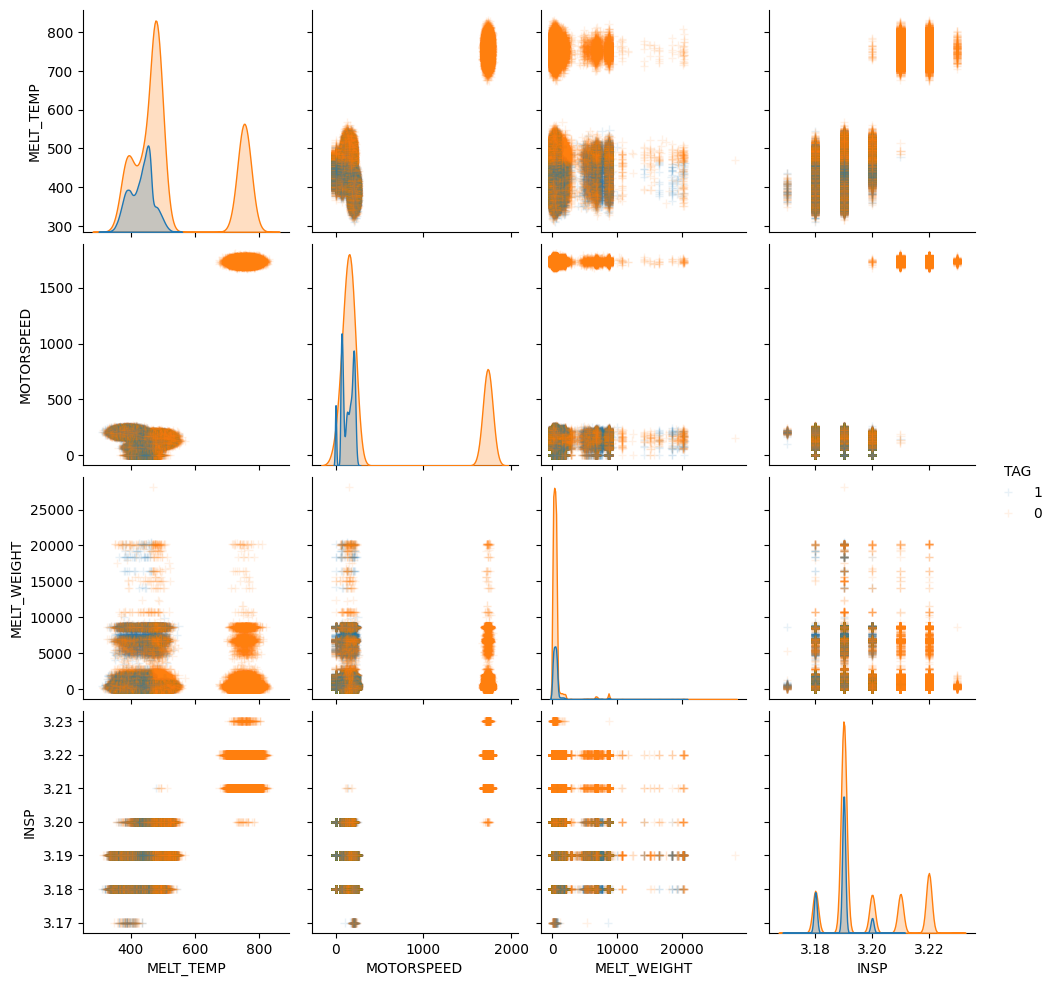

Execution time: 57.484413385391235 seconds


In [23]:
# https://seaborn.pydata.org/generated/seaborn.pairplot.html
start_time = time.time()

sns.pairplot(df_rand, diag_kind='kde', hue='TAG', hue_order=[1, 0], plot_kws=dict(marker="+", linewidth=1, alpha=0.1))
plt.show()

end_time = time.time()
print(f"Execution time: {end_time - start_time} seconds")

**Time-series Plot**

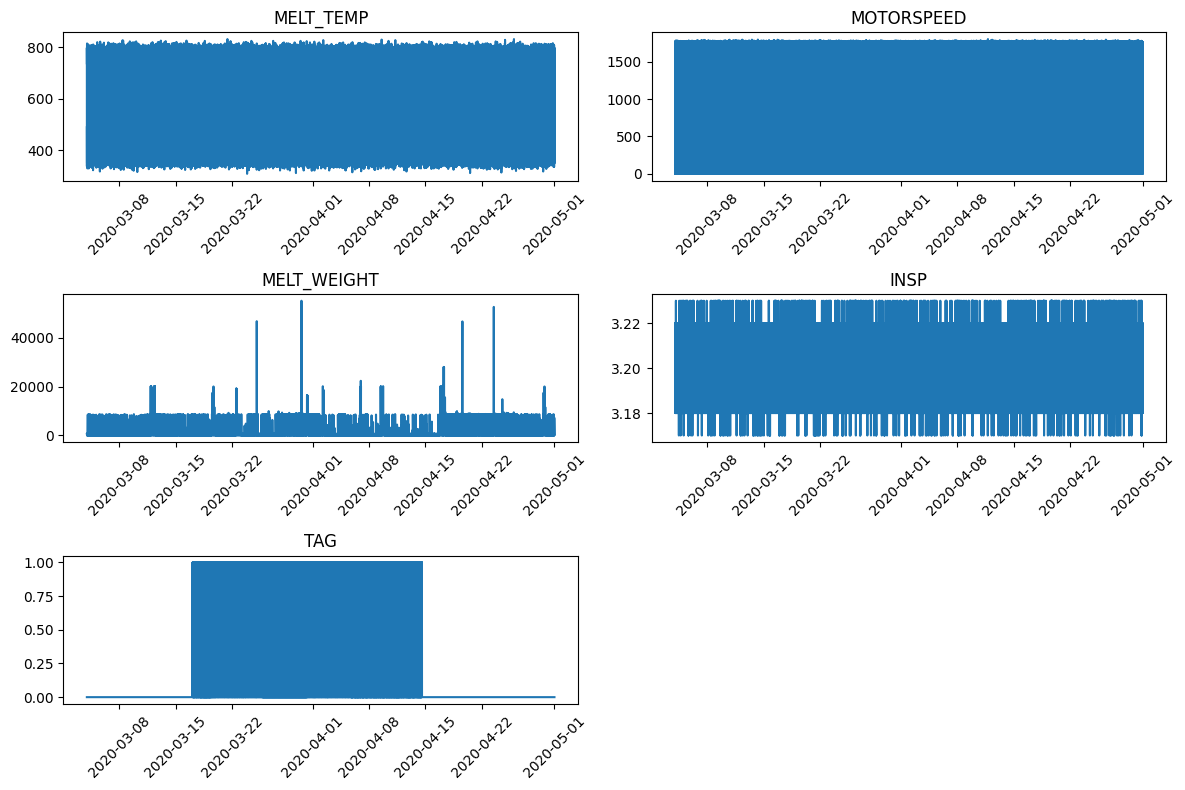

In [25]:
plt.figure(figsize=(12,8))

selected_col = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG']
for i, col in enumerate(selected_col):
    num = 321+i
    plt.subplot(num)
    plt.plot(df[col])
    plt.xticks(rotation=45)
    plt.title(col)
    
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)    
plt.tight_layout()
plt.show()

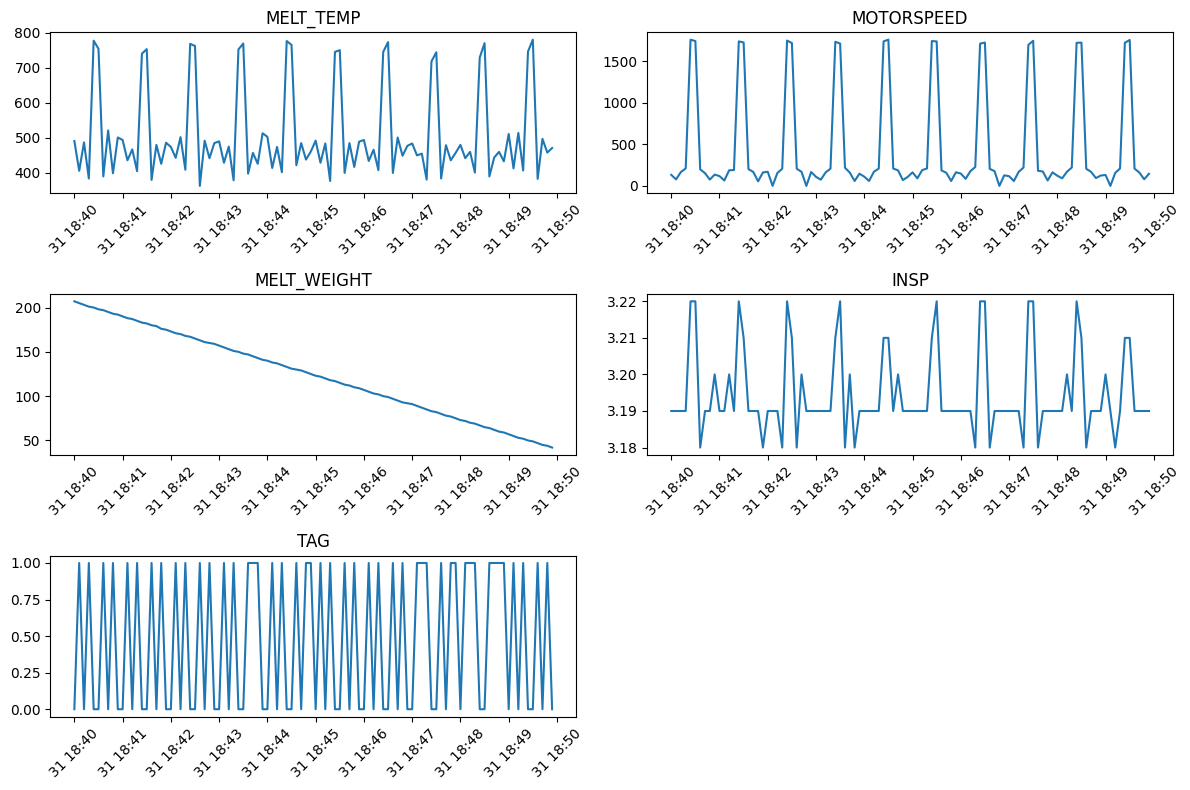

In [28]:
import matplotlib.dates as mdates

selected_col = ['MELT_TEMP', 'MOTORSPEED', 'MELT_WEIGHT', 'INSP', 'TAG']
plt.figure(figsize=(12,8))

for i, col in enumerate(selected_col):
    num = 321+i
    plt.subplot(num)
    plt.plot(df[col][400000:400100])
    plt.xticks(rotation=45)
    plt.title(col)
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M')) # %Y-%m-%d %H:%M:%S
    
plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.2, hspace=0.35)    
plt.tight_layout()
plt.show()

1분(10개 관측치)마다 패턴을 보였으므로, 향후 모델링에서 1분을 timestep으로 활용